In [1]:
%pwd
%cd /Users/elin/Documents/cam/PWML/L48Project/tti

/Users/elin/Documents/cam/PWML/L48Project/tti


In [2]:
import os

import numpy as np
import pandas as pd
from tqdm.notebook import trange
from tqdm import tqdm
import importlib
import matplotlib.pyplot as plt

import tti_explorer
from tti_explorer import config, utils
from tti_explorer.case import simulate_case, CaseFactors
from tti_explorer.contacts import EmpiricalContactsSimulator
from tti_explorer.strategies import TTIFlowModel, RETURN_KEYS

importlib.reload(tti_explorer)
importlib.reload(tti_explorer.config)
importlib.reload(tti_explorer.utils)
importlib.reload(tti_explorer.case)
importlib.reload(tti_explorer.strategies)
importlib.reload(tti_explorer.contacts)


<module 'tti_explorer.contacts' from '/Users/elin/Documents/cam/PWML/L48Project/tti/tti_explorer/contacts.py'>

In [3]:
def print_doc(func):
    print(func.__doc__)

In [4]:
name = 'S3_test_based_TTI'
rng = np.random.RandomState(0)
#case_config = config.get_case_config("delve_mostly_uni")
case_config = config.get_case_config("delve_mostly_old")
#case_config = config.get_case_config("delve_mostly_twenties")
contacts_config = config.get_contacts_config("delve")
print(contacts_config)
policy_config = config.get_strategy_configs("delve", name)[name]
factor_config = utils.get_sub_dictionary(policy_config, config.DELVE_CASE_FACTOR_KEYS)
strategy_config = utils.get_sub_dictionary(policy_config, config.DELVE_STRATEGY_FACTOR_KEYS)

{'home_sar': 0.3, 'work_sar': 0.045, 'other_sar': 0.045, 'period': 10, 'asymp_factor': 0.5}


In [5]:
def load_csv(pth):
    return np.loadtxt(pth, dtype=int, skiprows=1, delimiter=",")

In [6]:
path_to_bbc_data = os.path.join("data", "processed")

child_no_school = load_csv(os.path.join(path_to_bbc_data, "childnoschool.csv"))
child_school = load_csv(os.path.join(path_to_bbc_data, "childschool.csv"))
university = load_csv(os.path.join(path_to_bbc_data, "university.csv"))
twenties = load_csv(os.path.join(path_to_bbc_data, "twenties.csv"))
thirties_to_fifties = load_csv(os.path.join(path_to_bbc_data, "thirtiestofifties.csv"))
fifties_to_seventies = load_csv(os.path.join(path_to_bbc_data, "fiftiestoseventies.csv"))
seventy_plus = load_csv(os.path.join(path_to_bbc_data, "seventyplus.csv"))

In [7]:
simulate_contacts = EmpiricalContactsSimulator(child_no_school, child_school, university, twenties, thirties_to_fifties, fifties_to_seventies, seventy_plus, rng)
tti_model = TTIFlowModel(rng, **strategy_config)

In [8]:
n_seperate_starting_cases = 1000
n_repetitions = 10
outputs = list()
death_rates = []

for i in tqdm(range(n_seperate_starting_cases)):
    old_probs = []
    for i in range(n_repetitions):
        case = simulate_case(rng, p_for_categories_continued=old_probs, **case_config)
        case_factors = CaseFactors.simulate_from(rng, case, **factor_config)
        (contacts, old_probs, death_rate) = simulate_contacts(case, **contacts_config)
        res = tti_model(case, contacts, case_factors)
        outputs.append(res)
        death_rates.append(death_rate)


100%|██████████| 1000/1000 [00:10<00:00, 94.84it/s]


In [9]:
# This cell is mosltly just formatting results...
to_show = [
    RETURN_KEYS.base_r,
    RETURN_KEYS.reduced_r,
    RETURN_KEYS.man_trace,
    RETURN_KEYS.app_trace,
    RETURN_KEYS.tests
]

# scale factor to turn simulation numbers into UK population numbers
nppl = case_config['infection_proportions']['nppl']
scales = [1, 1, nppl, nppl, nppl]

results = pd.DataFrame(
    outputs
).mean(
    0
).loc[
    to_show
].mul(
    scales
).to_frame(
    name=f"Simulation results: {name.replace('_', ' ')}"
).rename(
    index=lambda x: x + " (k per day)" if x.startswith("#") else x
)

results.round(3)

,Simulation results: S3 test based TTI
Base R,3.938
Effective R,1.326
# Manual Traces (k per day),107.604
# App Traces (k per day),15.324
# Tests Needed (k per day),90.132


In [10]:
relevant_death_rate_sum = sum(n for n in death_rates if n != -1)
relevant_death_rate_count = sum(1 for n in death_rates if n != -1)
dr = relevant_death_rate_sum / relevant_death_rate_count
print("Average Death Rate: " + str(round(dr*100,2)) + "%")

Average Death Rate: 1.47%


# Sensitivity analysis for new variant

In [22]:
#loweround = 1.4
#upperBound = 1.7
#new_variant = [1, 1.25, 1.5, 1.75, 2]
new_variant = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]


n_seperate_starting_cases = 1000
n_repetitions = 10

efficent_R_values = list()
base_R_values = list()

def find_R(variant):
    contacts_config = config.get_contacts_config("delve")
    contacts_config = dict(home_sar=contacts_config.get("home_sar") * variant,
                           work_sar=contacts_config.get("work_sar") * variant, 
                           other_sar=contacts_config.get("other_sar") * variant, 
                           period=10, asymp_factor=0.5)
    print(contacts_config)
    
    for i in tqdm(range(n_seperate_starting_cases)):
        old_probs = []
        for i in range(n_repetitions):
            case = simulate_case(rng, p_for_categories_continued=old_probs, **case_config)
            case_factors = CaseFactors.simulate_from(rng, case, **factor_config)
            (contacts, old_probs, death_rate) = simulate_contacts(case, **contacts_config)
            res = tti_model(case, contacts, case_factors)
            efficent_R.append(res)
            
    scaled_R = pd.DataFrame(
                    efficent_R
                ).mean(
                    0
                ).loc[
                    to_show
                ].mul(
                    scales
                )
    efficent_R_values.append(scaled_R.get("Effective R"))
    base_R_values.append(scaled_R.get("Base R"))

efficent_R = list()
for i in new_variant:
    find_R(i)
      
print(efficent_R_values)


    


  1%|          | 7/1000 [00:00<00:14, 69.27it/s]

{'home_sar': 0.3, 'work_sar': 0.045, 'other_sar': 0.045, 'period': 10, 'asymp_factor': 0.5}


  1%|          | 9/1000 [00:00<00:11, 88.77it/s]

{'home_sar': 0.33, 'work_sar': 0.0495, 'other_sar': 0.0495, 'period': 10, 'asymp_factor': 0.5}


  1%|          | 9/1000 [00:00<00:11, 84.21it/s]

{'home_sar': 0.36, 'work_sar': 0.054, 'other_sar': 0.054, 'period': 10, 'asymp_factor': 0.5}


  1%|          | 7/1000 [00:00<00:15, 62.68it/s]

{'home_sar': 0.39, 'work_sar': 0.058499999999999996, 'other_sar': 0.058499999999999996, 'period': 10, 'asymp_factor': 0.5}


  1%|          | 8/1000 [00:00<00:13, 74.93it/s]

{'home_sar': 0.42, 'work_sar': 0.063, 'other_sar': 0.063, 'period': 10, 'asymp_factor': 0.5}


  1%|          | 8/1000 [00:00<00:12, 77.67it/s]

{'home_sar': 0.44999999999999996, 'work_sar': 0.0675, 'other_sar': 0.0675, 'period': 10, 'asymp_factor': 0.5}


  1%|          | 8/1000 [00:00<00:12, 77.67it/s]

{'home_sar': 0.48, 'work_sar': 0.072, 'other_sar': 0.072, 'period': 10, 'asymp_factor': 0.5}


  1%|          | 9/1000 [00:00<00:11, 87.74it/s]

{'home_sar': 0.51, 'work_sar': 0.0765, 'other_sar': 0.0765, 'period': 10, 'asymp_factor': 0.5}


  1%|          | 7/1000 [00:00<00:15, 62.91it/s]

{'home_sar': 0.54, 'work_sar': 0.081, 'other_sar': 0.081, 'period': 10, 'asymp_factor': 0.5}


  1%|          | 8/1000 [00:00<00:12, 79.26it/s]

{'home_sar': 0.57, 'work_sar': 0.08549999999999999, 'other_sar': 0.08549999999999999, 'period': 10, 'asymp_factor': 0.5}


100%|██████████| 1000/1000 [00:10<00:00, 96.83it/s]


[1.2931097095040438, 1.3689705749968633, 1.395988475140555, 1.4540088462411158, 1.5115429687656368, 1.5843484072550273, 1.6304636789013855, 1.6970344033237, 1.7568661395253515, 1.7950364059617117]


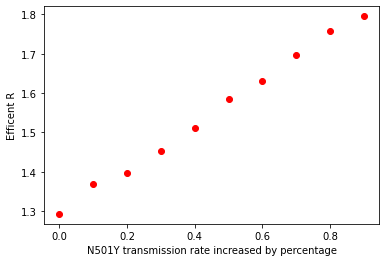

In [23]:
plt.ylabel('Efficent R')
plt.xlabel('N501Y transmission rate increased by percentage')
label_variant = [n - 1 for n in new_variant]
plt.plot(label_variant, efficent_R_values , 'ro')
plt.show()

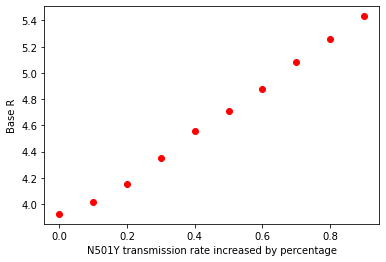

In [24]:
plt.ylabel('Base R')
plt.xlabel('N501Y transmission rate increased by percentage')
label_variant = [n - 1 for n in new_variant]
plt.plot(label_variant, base_R_values , 'ro')
plt.show()